In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('filtered_training_df_without_outliers.xlsx')

training_df.head()

,339,341,342,344,345,346,348,349,351,352,...,2499,2501,2503,2505,2507,2509,2511,2514,2516,RWC
0,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,98.373025
1,0.0889,0.1040,0.1000,0.1056,0.0896,0.0839,0.0836,0.0877,0.0831,0.0723,...,0.0394,0.0368,0.0344,0.0330,0.0349,0.0334,0.0332,0.0340,0.0356,99.923489
2,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,0.0722,...,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479,96.795629
3,0.1052,0.0733,0.1128,0.1072,0.0985,0.1134,0.1044,0.0855,0.0549,0.0608,...,0.0278,0.0261,0.0245,0.0251,0.0232,0.0225,0.0220,0.0201,0.0292,94.518349
4,0.1626,0.1466,0.1476,0.1072,0.1062,0.1064,0.0718,0.1099,0.0989,0.0913,...,0.0353,0.0347,0.0345,0.0365,0.0360,0.0320,0.0317,0.0314,0.0342,95.493562


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['RWC'])
y = training_df['RWC']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 13:46:33,753] A new study created in memory with name: no-name-8ecbe393-6c31-4b49-be38-71901d07231b
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:34,913] Trial 0 finished with value: 859.9556743595488 and parameters: {'n_components': 939, 'max_iter': 518}. Best is trial 0 with value: 859.9556743595488.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:35,035] Trial 1 finished with value: 859.955674359552 and parameters: {'n_components': 192, 'max_iter': 624}. Best is trial 0 with value: 859.9556743595488.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y r

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:40,119] Trial 23 finished with value: 859.9556743595455 and parameters: {'n_components': 483, 'max_iter': 1000}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:40,216] Trial 24 finished with value: 859.955674359552 and parameters: {'n_components': 161, 'max_iter': 792}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13

[I 2024-03-13 13:46:45,042] Trial 44 finished with value: 859.9556743595468 and parameters: {'n_components': 555, 'max_iter': 481}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:45,201] Trial 45 finished with value: 859.9556743595455 and parameters: {'n_components': 493, 'max_iter': 878}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:45,572] Trial 46 finished with value: 859.9556743595491 and parameters: {'n_components': 641, 'max_iter': 822}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:51,523] Trial 66 finished with value: 859.955674359552 and parameters: {'n_components': 301, 'max_iter': 820}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:51,632] Trial 67 finished with value: 859.9556743595485 and parameters: {'n_components': 375, 'max_iter': 997}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 

[I 2024-03-13 13:46:55,419] Trial 87 finished with value: 859.9556743595505 and parameters: {'n_components': 393, 'max_iter': 565}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:55,588] Trial 88 finished with value: 859.9556743595455 and parameters: {'n_components': 485, 'max_iter': 787}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 33
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-13 13:46:55,795] Trial 89 finished with value: 859.9556743595468 and parameters: {'n_components': 535, 'max_iter': 689}. Best is trial 10 with value: 326.9345493954403.
/Users/trangtran/anaconda3/lib/python3.11/

Number of finished trials:  100
Best trial:
  Value: 326.9345493954403
  Params: 
    n_components: 4
    max_iter: 396
Mean Squared Error: 326.9345493954403
Root Mean Squared Error: 18.081331516109103
R-Squared value: 0.561436146511622


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
354: 0.8739006702059998
355: 0.8673988541891492
344: 0.7340531119393316


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 13:48:47,042] A new study created in memory with name: no-name-a947490e-19ea-4a65-87ae-f35b480f8c50
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or c

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+01, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+00, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.072e+01, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+01, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.772e+02, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+02, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e+01, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+02, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.679e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.952e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_

Number of finished trials:  100
Best trial:
  Value: 330.66420442737774
  Params: 
    alpha: 0.9985606337918491
    l1_ratio: 0.0020843557448036957
    max_iter: 264
Mean Squared Error: 330.66420442737774
Root Mean Squared Error: 18.184174559967733
R-Squared value: 0.5564330292638013


/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.952e+03, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_descent(


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
367: 1.8262667114329574
354: 1.6443882425139933
355: 1.6172880621687975


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [20]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 14:00:41,143] A new study created in memory with name: no-name-d886c13b-8a92-4c3a-9f38-ac8c4f3dcac8
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:41,202] Trial 0 finished with value: 5330.408910987999 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 5330.408910987999.
/var/folders/

[I 2024-03-13 14:00:41,427] Trial 9 finished with value: 202402.09219773184 and parameters: {'alpha': 0.6402713827422477, 'gamma': 1.6968526427052133e-06, 'kernel': 'linear'}. Best is trial 5 with value: 261.80077458207427.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:41,457] Trial 10 finished with value: 278.6753435999109 and parameters: {'alpha': 0.00391594964095

[I 2024-03-13 14:00:41,823] Trial 19 finished with value: 259.67498625229837 and parameters: {'alpha': 0.0991829141394898, 'gamma': 0.00023585393150057094, 'kernel': 'rbf'}. Best is trial 16 with value: 68.8619552323794.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:41,856] Trial 20 finished with value: 5328.336267197909 and parameters: {'alpha': 0.3158666178020566,

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:42,289] Trial 30 finished with value: 58.91451971604918 and parameters: {'alpha': 0.7716288161179338, 'gamma': 0.0007769617680970931, 'kernel': 'rbf'}. Best is trial 30 with value: 58.91451971604918.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been de

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:42,623] Trial 39 finished with value: 5330.408910988087 and parameters: {'alpha': 0.907010395561327, 'gamma': 5.182797866153286, 'kernel': 'rbf'}. Best is trial 30 with value: 58.91451971604918.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been depr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:42,987] Trial 49 finished with value: 803.2313763283769 and parameters: {'alpha': 0.7542454760891311, 'gamma': 1.011114290599967e-06, 'kernel': 'rbf'}. Best is trial 30 with value: 58.91451971604918.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been de

[I 2024-03-13 14:00:43,310] Trial 58 finished with value: 351495.48543512775 and parameters: {'alpha': 0.23772548342224045, 'gamma': 0.0005936338209943242, 'kernel': 'linear'}. Best is trial 54 with value: 58.00808236758976.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:43,341] Trial 59 finished with value: 749.6013904132716 and parameters: {'alpha': 0.8145587286837

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:43,733] Trial 68 finished with value: 647.0067639023533 and parameters: {'alpha': 0.8346007323508557, 'gamma': 0.003814590582271108, 'kernel': 'rbf'}. Best is trial 54 with value: 58.00808236758976.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been 

[I 2024-03-13 14:00:44,074] Trial 77 finished with value: 68.14039812913127 and parameters: {'alpha': 0.8748156072905489, 'gamma': 0.0005380487405443974, 'kernel': 'rbf'}. Best is trial 54 with value: 58.00808236758976.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:44,106] Trial 78 finished with value: 102.05479313953617 and parameters: {'alpha': 0.925707995786844, 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:44,464] Trial 87 finished with value: 292.9451180707563 and parameters: {'alpha': 0.973882490866069, 'gamma': 6.415173066398242e-05, 'kernel': 'rbf'}. Best is trial 54 with value: 58.00808236758976.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been 

[I 2024-03-13 14:00:44,760] Trial 96 finished with value: 59.10412171618113 and parameters: {'alpha': 0.7861428911340319, 'gamma': 0.000758410048304311, 'kernel': 'rbf'}. Best is trial 54 with value: 58.00808236758976.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-13 14:00:44,794] Trial 97 finished with value: 5330.408910988087 and parameters: {'alpha': 0.7927108225247088, '

Number of finished trials:  100
Best trial:
  Value: 58.00808236758976
  Params: 
    alpha: 0.9289252652569148
    gamma: 0.0007496325447661198
    kernel: rbf
Mean Squared Error: 58.00808236758976
Root Mean Squared Error: 7.6163037208077355
R-Squared value: 0.9221855010929714


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
373: 1803.6589412456467
342: 1152.5075829822767
357: 980.895820066545


In [31]:
# Add Gaussian Noise
noise_mean = 0
noise_std = 0.05  # Adjust the standard deviation for the Gaussian noise

# Generate Gaussian noise with the same shape as your input features
gaussian_noise_train = np.random.normal(noise_mean, noise_std, X_train.shape)
gaussian_noise_test = np.random.normal(noise_mean, noise_std, X_test.shape)

# Add the noise to the training and testing data
X_train_noisy = X_train + gaussian_noise_train
X_test_noisy = X_test + gaussian_noise_test

# Retrain the Model
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

best_krr.fit(X_train_noisy, y_train)

# Evaluate Changes in Predictions
# Predict on the noisy dataset
y_pred_noisy = best_krr.predict(X_test_noisy)

# Compute the average absolute difference in predictions
average_absolute_difference = np.mean(np.abs(y_pred - y_pred_noisy))
print(f"Average Absolute Difference in Predictions: {average_absolute_difference}")


Average Absolute Difference in Predictions: 0.04598647786036292


In [32]:
# Get the learned coefficients
coefficients = best_krr.dual_coef_

# Calculate the importance scores for each feature
feature_importances = np.abs(np.dot(coefficients, X_train_noisy))

# Normalize the feature importances
feature_importances /= np.sum(feature_importances)

# Get the names of the features
feature_names = X.columns 

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
355: 0.004394638834470092
354: 0.0034454847639718966
367: 0.003143695398699056


In [33]:
# Make predictions
y_pred = best_krr.predict(X_test_noisy)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 57.42029484160033
Root Mean Squared Error: 7.577618018981976
R-Squared value: 0.9229739841789805


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 2


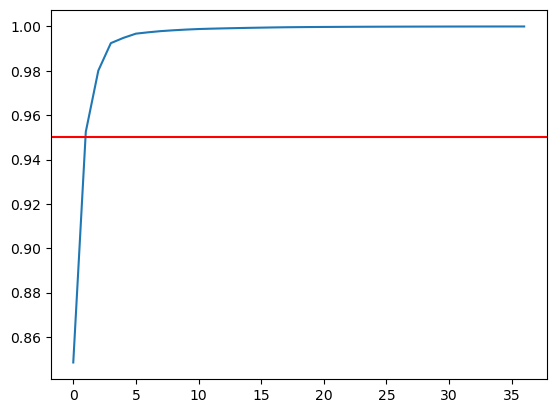

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 310.4926121792856
Root Mean Squared Error: 17.620800554438087
R-Squared value: 0.5834920575729182


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1910: 0.003106168882857606
1913: 0.003095948864823212
1927: 0.0030882603150888025


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 13:50:01,234] A new study created in memory with name: no-name-9cf1181f-bfe5-4d27-9f12-c4c67470eb03
[I 2024-03-13 13:50:01,846] Trial 0 finished with value: 771.7446003598343 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 771.7446003598343.
[I 2024-03-13 13:50:02,199] Trial 1 finished with value: 905.8169512096102 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 771.7446003598343.
[I 2024-03-13 13:50:02,484] Trial 2 finished with value: 815.000766926194 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 771.7446003598343.
[I 2024-03-13 13:50:02,877] Trial 3 finished with value: 575.9949595195665 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 575.99

[I 2024-03-13 13:50:24,182] Trial 36 finished with value: 485.08889688994395 and parameters: {'n_estimators': 58, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 14 with value: 421.42390554199363.
[I 2024-03-13 13:50:24,537] Trial 37 finished with value: 780.5503383468584 and parameters: {'n_estimators': 81, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 7}. Best is trial 14 with value: 421.42390554199363.
[I 2024-03-13 13:50:24,927] Trial 38 finished with value: 723.7145827689623 and parameters: {'n_estimators': 65, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 4}. Best is trial 14 with value: 421.42390554199363.
[I 2024-03-13 13:50:26,759] Trial 39 finished with value: 457.18882913192056 and parameters: {'n_estimators': 139, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 14 with value: 421.42390554199363.
[I 2024-03-13 13:50:28,559] Trial 40 finished with value: 523.3872197931014 and paramet

[I 2024-03-13 13:51:19,415] Trial 72 finished with value: 415.7982307357229 and parameters: {'n_estimators': 88, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 72 with value: 415.7982307357229.
[I 2024-03-13 13:51:20,484] Trial 73 finished with value: 486.7930869762049 and parameters: {'n_estimators': 87, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 72 with value: 415.7982307357229.
[I 2024-03-13 13:51:21,402] Trial 74 finished with value: 512.3236312416994 and parameters: {'n_estimators': 93, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 72 with value: 415.7982307357229.
[I 2024-03-13 13:51:21,798] Trial 75 finished with value: 726.2289393596149 and parameters: {'n_estimators': 90, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 72 with value: 415.7982307357229.
[I 2024-03-13 13:51:23,009] Trial 76 finished with value: 474.89332956680306 and parameters: {'n

Best trial:
  Value: 378.4329783531674
  Params: 
    n_estimators: 78
    max_depth: 9
    min_samples_split: 12
    min_samples_leaf: 1
Mean Squared Error: 442.6713765594004
Root Mean Squared Error: 21.039757046111546
R-Squared value: 0.40618186394832234


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
354: 0.155981812571786
339: 0.08050282537370605
1894: 0.04968762947766191


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-13 13:52:07,317] A new study created in memory with name: no-name-8b4321f0-043b-4567-99c7-a095a8855138
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:52:11,069] Trial 0 finished with value: 453.97342458203207 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 453.97342458203207.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugges

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:52:45,339] Trial 14 finished with value: 310.2506566186788 and parameters: {'n_estimators': 56, 'max_depth': 8, 'learning_rate': 0.0978144269260402}. Best is trial 11 with value: 297.57749723408114.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:52:49,413] Trial 15 finis

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:53:28,989] Trial 28 finished with value: 319.23350872442023 and parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.06673210240051179}. Best is trial 20 with value: 290.2151674489043.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:53:33,055] Trial 29 fini

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:54:01,819] Trial 42 finished with value: 300.67625354982835 and parameters: {'n_estimators': 57, 'max_depth': 8, 'learning_rate': 0.0933356591488976}. Best is trial 35 with value: 290.184325445557.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:54:03,684] Trial 43 finish

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:54:27,134] Trial 56 finished with value: 285.50042845251755 and parameters: {'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.0960413877240621}. Best is trial 56 with value: 285.50042845251755.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:54:29,199] Trial 57 fini

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:55:05,655] Trial 70 finished with value: 310.72439737051815 and parameters: {'n_estimators': 78, 'max_depth': 8, 'learning_rate': 0.09084388145793341}. Best is trial 56 with value: 285.50042845251755.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:55:07,838] Trial 71 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:55:33,833] Trial 84 finished with value: 307.4007558715691 and parameters: {'n_estimators': 62, 'max_depth': 8, 'learning_rate': 0.09392373681472596}. Best is trial 77 with value: 277.49457497575884.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:55:36,071] Trial 85 fini

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:56:04,419] Trial 98 finished with value: 290.39122659401545 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.06526616518722586}. Best is trial 77 with value: 277.49457497575884.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-13 13:56:06,235] Trial 99 fin

Best trial:
  Value: 277.49457497575884
  Params: 
    n_estimators: 73
    max_depth: 7
    learning_rate: 0.09783596213395718
Mean Squared Error: 282.363180979401
Root Mean Squared Error: 16.803665700655944
R-Squared value: 0.621226068145585


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
354: 0.275024539357279
339: 0.1975528277045933
352: 0.058873793966457685


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-13 13:56:24,303] A new study created in memory with name: no-name-edc8a507-1cc8-4d1c-9dd8-08d1f5cdb39b
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[I 2024-03-13 13:56:27,984] Trial 6 finished with value: 789.1223044295369 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 2 with value: 479.68359051317833.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn1

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:56:36,323] Trial 19 finished with value: 454.13243728417524 and parameters: {'n_estimators': 92, 'max_depth': 9, 'learning_rate': 0.09325065924036391, 'min_child_weight': 2, 'subsample': 0.8805827658759505, 'colsample_bytree': 0.7772144339215246}. Best is trial 18 with value: 438.23731528908525.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:56:52,185] Trial 39 finished with value: 661.7909482288109 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.05955701538438372, 'min_child_weight': 2, 'subsample': 0.9080858955886343, 'colsample_bytree': 0.969445569923279}. Best is trial 26 with value: 304.190765096914.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:57:03,947] Trial 52 finished with value: 348.013906160319 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.05475660979679767, 'min_child_weight': 1, 'subsample': 0.9052377871579317, 'colsample_bytree': 0.9613911816303345}. Best is trial 26 with value: 304.190765096914.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:57:19,331] Trial 65 finished with value: 468.20149600987105 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.022837826679831932, 'min_child_weight': 1, 'subsample': 0.9451270348731148, 'colsample_bytree': 0.59552991767212}. Best is trial 26 with value: 304.190765096914.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:57:30,426] Trial 78 finished with value: 838.9436548892629 and parameters: {'n_estimators': 73, 'max_depth': 6, 'learning_rate': 0.08348975229420252, 'min_child_weight': 6, 'subsample': 0.9450858929334517, 'colsample_bytree': 0.7183792628961126}. Best is trial 26 with value: 304.190765096914.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

[I 2024-03-13 13:57:39,473] Trial 91 finished with value: 245.50815073313723 and parameters: {'n_estimators': 85, 'max_depth': 8, 'learning_rate': 0.09737223852772844, 'min_child_weight': 1, 'subsample': 0.9682204418697231, 'colsample_bytree': 0.9231254011783276}. Best is trial 91 with value: 245.50815073313723.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_8763/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1

Best trial:
  Value: 245.50815073313723
  Params: 
    n_estimators: 85
    max_depth: 8
    learning_rate: 0.09737223852772844
    min_child_weight: 1
    subsample: 0.9682204418697231
    colsample_bytree: 0.9231254011783276
Mean Squared Error: 245.50815073313723
Root Mean Squared Error: 15.668699714179771
R-Squared value: 0.6706649668949553


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1421: 0.41245824098587036
640: 0.18880809843540192
2491: 0.072898268699646
